In [1]:
from owlready2 import *
import spacy
from spacy.matcher import Matcher
from spacy.tokenizer import Tokenizer
import xml.sax
import json
import re

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation




----
# Pass 1:
- finds matches from a set of confident attributes using a Spacy matcher
    - preprocessing performed to remove punctuation adn convert to lowercase
- samples with no matches have attributes, title, and paragraph written to the the tissue_tmp_1.jsonl file

After first pass: 10519273 samples matched

In [5]:
def preprocess(input_str):
    punct_pattern = r'\ *[_&<>:-]+\ *'
    input_str = re.sub(punct_pattern, ' ', input_str)
    return input_str.lower().strip()

# load the BRENDA ontology
onto = get_ontology('http://purl.obolibrary.org/obo/bto.owl').load()

# load classes and synonyms
classes = {c.name: c.label.first() for c in onto.classes()}
class_synonyms = {c.name: c.hasExactSynonym + c.hasRelatedSynonym for c in onto.classes()}

# add additional synonyms
class_synonyms['BTO_0000440'] += ['stool']
class_synonyms['BTO_0005238'] += ['HEK293-T-REx']

# create a reverse mapping of labels to BRENDA ids
classes_reverse = {preprocess(c.label.first()): c.name for c in onto.classes() if c.label != []}
class_synonyms_reverse = {preprocess(s): c for c, syn in class_synonyms.items() for s in syn}
labels_reverse = {**classes_reverse, **class_synonyms_reverse}


In [4]:
# reverse mapping removes redundant end terms from the key where possible
redundant_end_terms = ('tissue', 'tissues', 'cell', 'cells')
additional_labels = {}
for key, value in labels_reverse.items():
    if key.endswith(redundant_end_terms):
        # add the key without the redundant end term
        additional_labels[' '.join(key.split()[:-1])] = value

for key, value in additional_labels.items():
    if key not in labels_reverse:
        labels_reverse[key] = value

nlp = spacy.load('en_core_web_lg')
# blank matcher with vocab from the large model
matcher = Matcher(nlp.vocab)
# standard tokenizer from spacy
tokenizer = Tokenizer(nlp.vocab)

patterns = []
for label in labels_reverse.keys():
    if label != '':
        tokens = tokenizer(label)
        pattern = [{'LOWER': token.lower_} for token in tokens]
        patterns.append(pattern)

matcher.add('bto', patterns, greedy='LONGEST')


In [34]:
class BioSamplesHandler(xml.sax.ContentHandler):
    '''
    SAX hander class to read in in formation from a BioSamples XMl file
    - Reads in the title, paragraph, and attributes of each sample into a dictionary
        - if no matching attribtue found, dictionary written as json to file for second pass
    - Found values written to provided sample_dict with the biosample_id as the key
    '''

    def __init__(self, positive_attributes, tmp_file, output_file):
        self.positive_attributes = positive_attributes
        self.tmp_file = tmp_file
        self.output_file = output_file
        self.biosample_id = ''
        self.cur_dict = {}
        self.attributes = {}
        self.attribute_name = ''
        self.is_title = False
        self.is_paragraph = False
        self.is_sra = False
        self.sra_id = ''
        self.count = 0
    
    def startDocument(self):
        open(self.tmp_file, 'w').close()
        open(self.output_file, 'w').close()

    def startElement(self, name, attrs):
        if name == 'BioSample':
            self.biosample_id = attrs['accession']
        elif name == 'Title':
            self.is_title = True
        elif name == 'Paragraph':
            self.is_paragraph = True
        elif name == 'Attribute':
            try:
                self.attribute_name = attrs['harmonized_name']
            except KeyError:
                self.attribute_name = attrs['attribute_name']
        elif name == 'Id':
            if 'db' in attrs and attrs['db'] == 'SRA':
                self.is_sra = True

    def characters(self, content):
        if self.is_title:
            self.cur_dict['title'] = content.lower()
            self.is_title = False
        elif self.is_paragraph:
            self.cur_dict['paragraph'] = content.lower()
            self.is_paragraph = False
        elif self.is_sra:
            self.sra_id = content
            self.is_sra = False
        elif self.attribute_name != '':
            self.attributes[self.attribute_name] = content.lower()
            self.attribute_name = ''

    def endElement(self, name):
        if name == 'BioSample':
            # check if there are any positive attributes and extract the tissue
            intersect = set(self.attributes.keys()).intersection(self.positive_attributes)
            matches = []
            if len(intersect) == 1:
                attribute_value = preprocess(self.attributes[list(intersect)[0]])
                # check if the attribute value is a BTO term using the matcher
                attribute_tokens = tokenizer(attribute_value)
                matches = matcher(attribute_tokens, as_spans=True)
            elif len(intersect) > 1:
                # if there are multiple positive attributes, check if any of the values are BTO terms
                for attribute in intersect:
                    attribute_value = preprocess(self.attributes[attribute])
                    attribute_tokens = tokenizer(attribute_value)
                    matches += matcher(attribute_tokens, as_spans=True)

            if matches == []:
                # no matches found, write the biosample content to a tmp file for second pass
                with open(self.tmp_file, 'a') as f:
                    self.cur_dict['biosample_id'] = self.biosample_id
                    self.cur_dict['attributes'] = self.attributes
                    self.cur_dict['sra_id'] = self.sra_id
                    json.dump(self.cur_dict, f)
                    f.write('\n')
            else:
                # matches found, add to output file
                tissue_matches = ','.join({m.text for m in matches})
                bto_matches = ','.join({labels_reverse[m.text.lower()] for m in matches})
                with open(self.output_file, 'a') as f:
                    json.dump({'biosample_id': self.biosample_id , 'sra_id': self.sra_id, 'tissue': tissue_matches, 'bto_matches': bto_matches}, f)
                    f.write('\n')
                
            self.attribute_name = ''
            self.attributes = {}
            self.cur_dict = {}
            self.biosample_id = ''
            self.sra_id = ''
            self.count += 1
            if self.count % 1000000 == 0:
                print(self.count, "samples parsed")


    def endDocument(self):
        print("Finished parsing BioSamples XML file")
                


Some BioSample entries have no SRA identifier listed but SRA data is available from the link:
https://www.ncbi.nlm.nih.gov/sra?LinkName=biosample_sra&from_uid=BIOSAMPLE_NUMERICAL

where BIOSAMPLE_ID is the numerical ID of the biosample

In [106]:
positive_attributes = {'tissue', 'cell_type', 'cell_line', 'cell_subtype', 'source_name', 'host_tissue_sampled', 'body_habitat', 'body_product', 'host_body_product', 'host_body_habitat'}

# parse the BioSamples XML file
parser = xml.sax.make_parser()
handler = BioSamplesHandler(positive_attributes, '/home/ec2-user/workspace/data/results/tissue_tmp_1.jsonl', '/home/ec2-user/workspace/data/results/tissue_output.jsonl')
parser.setContentHandler(handler)

# comment out the following line to rerun the parser
# parser.parse('/home/ec2-user/workspace/data/biosample_set.xml')


1000000 samples parsed
2000000 samples parsed
3000000 samples parsed
4000000 samples parsed
5000000 samples parsed
6000000 samples parsed
7000000 samples parsed
8000000 samples parsed
9000000 samples parsed
10000000 samples parsed
11000000 samples parsed
12000000 samples parsed
13000000 samples parsed
14000000 samples parsed
15000000 samples parsed
16000000 samples parsed
17000000 samples parsed
18000000 samples parsed
19000000 samples parsed
20000000 samples parsed
21000000 samples parsed
22000000 samples parsed
23000000 samples parsed
24000000 samples parsed
25000000 samples parsed
26000000 samples parsed
27000000 samples parsed
28000000 samples parsed
29000000 samples parsed
30000000 samples parsed
31000000 samples parsed
32000000 samples parsed
33000000 samples parsed
Finished parsing BioSamples XML file


----
# Pass 2
- Runs the Spacy matcher with no optional terms on all the attributes

!! Code was run in a sperate file using GNU parallel for faster execution !!

After second pass: 
- Additional 6205050 samples matched    
- Total 16724323 samples matched

In [16]:
from owlready2 import *
import spacy
from spacy.matcher import Matcher
from spacy.tokenizer import Tokenizer
import xml.sax
import orjson as json
import re
import sys

def preprocess(input_str):
    punct_pattern = r'\ *[_&<>:-]+\ *'
    input_str = re.sub(punct_pattern, ' ', input_str)   
    return input_str.lower().strip()


# file will read an input file that is in the format tissue_tmp_1ax and will output a file in the format tissue_tmp_2ax.jsonl

# load the BRENDA ontology
onto = get_ontology('http://purl.obolibrary.org/obo/bto.owl').load()

# load classes and synonyms
classes = {c.name: c.label.first() for c in onto.classes()}
class_synonyms = {c.name: c.hasExactSynonym + c.hasRelatedSynonym for c in onto.classes()}

# add additional synonyms
class_synonyms['BTO_0000440'] += ['stool']
class_synonyms['BTO_0005238'] += ['HEK293-T-REx']

# create a reverse mapping of labels to BRENDA ids
classes_reverse = {preprocess(c.label.first()): c.name for c in onto.classes() if c.label != []}
class_synonyms_reverse = {preprocess(s): c for c, syn in class_synonyms.items() for s in syn}
labels_reverse = {**classes_reverse, **class_synonyms_reverse}

nlp = spacy.load('en_core_web_lg')
# blank matcher with vocab from the large model
matcher = Matcher(nlp.vocab)
# standard tokenizer from spacy
tokenizer = Tokenizer(nlp.vocab)

patterns = []
for label in labels_reverse.keys():
    tokens = tokenizer(label)
    pattern = [{'LOWER': token.lower_} for token in tokens]
    patterns.append(pattern)

matcher.add('bto', patterns, greedy='LONGEST')


assert len(sys.argv) == 2, "Please provide an input file"
input_file = sys.argv[1]
output_file = input_file.replace('tmp_1', 'output_2')
tmp_file = input_file.replace('tmp_1', 'tmp_2')

open(output_file, 'w').close()
open(tmp_file, 'w').close()

with open(input_file, 'r') as f:
    print("Starting second pass for ", input_file)
    for line in f:
        cur_dict = {} # stores the data to be written to the output file if applicable
        matches = [] # stores the matches for the current biosample
        # biosample_dict stores the biosample content
        biosample_dict = json.loads(line)
        cur_dict['biosample_id'] = biosample_dict['biosample_id']
        cur_dict['sra_id'] = biosample_dict['sra_id']
        # attributes is a dictionary of the biosample attributes
        attributes = biosample_dict['attributes']
        for attribute_name in attributes:
            attribute_value = preprocess(attributes[attribute_name])
            attribute_tokens = tokenizer(attribute_value)
            matches += matcher(attribute_tokens, as_spans=True)

        if matches != []:
            tissue_matches = ','.join({m.text for m in matches})
            bto_matches = ','.join({labels_reverse[m.text.lower()] for m in matches})
            cur_dict['tissue'] = tissue_matches
            cur_dict['bto_matches'] = bto_matches
            with open(output_file, 'ab') as f:
                f.write(json.dumps(cur_dict))
                f.write(b'\n')

        else:
            # no matches found in the attributes, writes the biosample content to a tmp file for third pass
            with open(tmp_file, 'ab') as f:
                f.write(json.dumps(biosample_dict))
                f.write(b'\n')

    print("Finished parsing", input_file)


----
# Pass 1 Re-run:
- finds matches from a set of confident attributes using a Spacy matcher
    - preprocessing performed to remove punctuation adn convert to lowercase
- samples with no matches have attributes, title, and paragraph written to the the tissue_tmp_1.jsonl file
## Changes
- want to re run pass 1 to update the tissue_output_1.jsonl with more info
    - store the exact value from the biosamples metadata that the match came from
    - store the location that the match came from (attribute X, title, paragraph...)

- changed output to use '\t' as a delimiter due to issues with commas in attribute values

In [ ]:
from owlready2 import *
import spacy
from spacy.matcher import Matcher
from spacy.tokenizer import Tokenizer
import xml.sax
import json
import re

def preprocess(input_str):
    punct_pattern = r'\ *[_&<>:-]+\ *'
    input_str = re.sub(punct_pattern, ' ', input_str)
    return input_str.lower().strip()

# load the BRENDA ontology
onto = get_ontology('http://purl.obolibrary.org/obo/bto.owl').load()

# load classes and synonyms
classes = {c.name: c.label.first() for c in onto.classes()}
class_synonyms = {c.name: c.hasExactSynonym + c.hasRelatedSynonym for c in onto.classes()}

# add additional synonyms
class_synonyms['BTO_0000440'] += ['stool']
class_synonyms['BTO_0005238'] += ['HEK293-T-REx']

# create a reverse mapping of labels to BRENDA ids
classes_reverse = {preprocess(c.label.first()): c.name for c in onto.classes() if c.label != []}
class_synonyms_reverse = {preprocess(s): c for c, syn in class_synonyms.items() for s in syn}
labels_reverse = {**classes_reverse, **class_synonyms_reverse}

# reverse mapping removes redundant end terms from the key where possible
redundant_end_terms = ('tissue', 'tissues', 'cell', 'cells')
additional_labels = {}
for key, value in labels_reverse.items():
    if key.endswith(redundant_end_terms):
        # add the key without the redundant end term
        additional_labels[' '.join(key.split()[:-1])] = value

for key, value in additional_labels.items():
    if key not in labels_reverse:
        labels_reverse[key] = value

nlp = spacy.load('en_core_web_lg')
# blank matcher with vocab from the large model
matcher = Matcher(nlp.vocab)
# standard tokenizer from spacy
tokenizer = Tokenizer(nlp.vocab)

patterns = []
for label in labels_reverse.keys():
    if label != '':
        tokens = tokenizer(label)
        pattern = [{'LOWER': token.lower_} for token in tokens]
        patterns.append(pattern)

matcher.add('bto', patterns, greedy='LONGEST')

class BioSamplesHandler(xml.sax.ContentHandler):
    '''
    SAX hander class to read in in formation from a BioSamples XMl file
    - Reads in the title, paragraph, and attributes of each sample into a dictionary
        - if no matching attribtue found, dictionary written as json to file for second pass
    - Found values written to provided sample_dict with the biosample_id as the key
    '''

    def __init__(self, positive_attributes, tmp_file, output_file):
        self.positive_attributes = positive_attributes
        self.output_file = output_file
        self.tmp_file = tmp_file
        self.biosample_id = ''
        self.cur_dict = {}
        self.attributes = {}
        self.attribute_name = ''
        self.is_title = False
        self.is_paragraph = False
        self.is_sra = False
        self.sra_id = ''
        self.count = 0

    
    def startDocument(self):
        open(self.output_file, 'w').close()
        open(self.tmp_file, 'w').close()
        print("Parsing BioSamples XML file...")

    def startElement(self, name, attrs):
        if name == 'BioSample':
            self.biosample_id = attrs['accession']
        elif name == 'Title':
            self.is_title = True
        elif name == 'Paragraph':
            self.is_paragraph = True
        elif name == 'Attribute':
            try:
                self.attribute_name = attrs['harmonized_name']
            except KeyError:
                self.attribute_name = attrs['attribute_name']
        elif name == 'Id':
            if 'db' in attrs and attrs['db'] == 'SRA':
                self.is_sra = True

    def characters(self, content):
        if self.is_title:
            self.cur_dict['title'] = content.lower()
            self.is_title = False
        elif self.is_paragraph:
            self.cur_dict['paragraph'] = content.lower()
            self.is_paragraph = False
        elif self.is_sra:
            self.sra_id = content
            self.is_sra = False
        elif self.attribute_name != '':
            self.attributes[self.attribute_name] = content.lower()
            self.attribute_name = ''

    def endElement(self, name):
        if name == 'BioSample':
            attribute_vals = []
            text_matches = []
            # check if there are any positive attributes and extract the tissue
            intersect = set(self.attributes.keys()).intersection(self.positive_attributes)
            matches = []
            if len(intersect) == 1:
                attribute_value = preprocess(self.attributes[list(intersect)[0]])
                # check if the attribute value is a BTO term using the matcher
                attribute_tokens = tokenizer(attribute_value)
                matches = matcher(attribute_tokens, as_spans=True)
                # add the attribute name and value to a list if there is a match
                if matches != []:
                    # add the attribute name and text for each match
                    for _ in matches:
                        attribute_vals.append(list(intersect)[0])
                        text_matches.append(self.attributes[list(intersect)[0]])

            elif len(intersect) > 1:
                # if there are multiple positive attributes, check if any of the values are BTO terms
                for attribute in intersect:
                    attribute_value = preprocess(self.attributes[attribute])
                    attribute_tokens = tokenizer(attribute_value) # check if the attribute value is a BTO term using the matcher
                    tmp_matches = matcher(attribute_tokens, as_spans=True)
                    matches += tmp_matches
                    if tmp_matches != []:
                        # add the attribute name and text for each match
                        for _ in tmp_matches:
                            attribute_vals.append(attribute)
                            text_matches.append(self.attributes[attribute])

            if matches == []:
                # no matches found, write to tmp file
                with open(self.tmp_file, 'a') as f:
                    self.cur_dict['biosample_id'] = self.biosample_id
                    self.cur_dict['attributes'] = self.attributes
                    self.cur_dict['sra_id'] = self.sra_id
                    json.dump(self.cur_dict, f)
                    f.write('\n')

            else:
                # matches found, add to output file
                tissue_matches = '\t'.join([m.text for m in matches])
                bto_matches = '\t'.join([labels_reverse[m.text.lower()] for m in matches])
                attributes = '\t'.join(attribute_vals)
                text = '\t'.join(text_matches)
                with open(self.output_file, 'a') as f:
                    json.dump({'biosample_id': self.biosample_id , 'sra_id': self.sra_id, 'source': attributes, 'text': text, 'tissue': tissue_matches, 'bto_matches': bto_matches}, f)
                    f.write('\n')
                
            self.attribute_name = ''
            self.attributes = {}
            self.cur_dict = {}
            self.biosample_id = ''
            self.sra_id = ''
            self.count += 1
            if self.count % 1000000 == 0:
                print(self.count, "samples parsed")


    def endDocument(self):
        print(self.count, "samples parsed")
        print("Finished parsing BioSamples XML file")
                

positive_attributes = {'tissue', 'cell_type', 'cell_line', 'cell_subtype', 'source_name', 'host_tissue_sampled', 'body_habitat', 'body_product', 'host_body_product', 'host_body_habitat'}

# parse the BioSamples XML file
parser = xml.sax.make_parser()
handler = BioSamplesHandler(positive_attributes, '/home/ec2-user/workspace/data/results/tissue_tmp_rerun_1.jsonl', '/home/ec2-user/workspace/data/results/tissue_output_1_rerun.jsonl')
parser.setContentHandler(handler)

# comment out the following line to rerun the parser
parser.parse('/home/ec2-user/workspace/data/biosample_set.xml')

# biosample_set.xml.gz redownloaded on 2023/09/15
# code run on 2023/09/15 at 1435 in a separate python file

# biosample_set.xml.gz redownloaded on 2023/10/06
# code run on 2023/10/06 at 1840 in a separate python file
# total samples parsed: 35369235

# code run on 2023/10/9 at 1735 in a separate python file




----
# Pass 2 Re-run
- stores more information about where the exact text match came from 
- run in parallel in separate file

In [ ]:
from owlready2 import *
import spacy
from spacy.matcher import Matcher
from spacy.tokenizer import Tokenizer
# import orjson as json
import json
import re
import sys



def preprocess(input_str):
    punct_pattern = r'\ *[_&<>:-]+\ *'
    input_str = re.sub(punct_pattern, ' ', input_str)
    return input_str.lower().strip()


# file will read an input file that is in the format tissue_tmp_1ax and will output a file in the format tissue_tmp_2ax.jsonl

# load the BRENDA ontology
onto = get_ontology('http://purl.obolibrary.org/obo/bto.owl').load()

# load classes and synonyms
classes = {c.name: c.label.first() for c in onto.classes()}
class_synonyms = {c.name: c.hasExactSynonym + c.hasRelatedSynonym for c in onto.classes()}

# add additional synonyms
class_synonyms['BTO_0000440'] += ['stool']
class_synonyms['BTO_0005238'] += ['HEK293-T-REx']

# create a reverse mapping of labels to BRENDA ids
classes_reverse = {preprocess(c.label.first()): c.name for c in onto.classes() if c.label != []}
class_synonyms_reverse = {preprocess(s): c for c, syn in class_synonyms.items() for s in syn}
labels_reverse = {**classes_reverse, **class_synonyms_reverse}

# DON'T REMOVE REDUNDANT END TERMS
# - leads to false positives for terms like "M cell" and "T cell"

nlp = spacy.load('en_core_web_lg')
# blank matcher with vocab from the large model
matcher = Matcher(nlp.vocab)
# standard tokenizer from spacy
tokenizer = Tokenizer(nlp.vocab)

patterns = []
for label in labels_reverse.keys():
    tokens = tokenizer(label)
    pattern = [{'LOWER': token.lower_} for token in tokens]
    patterns.append(pattern)

matcher.add('bto', patterns, greedy='LONGEST')


assert len(sys.argv) == 2, "Please provide an input file"
input_file = sys.argv[1]
output_file = input_file.replace('tmp_rerun_1', 'output_2_rerun')
tmp_file = input_file.replace('tmp_rerun_1', 'tmp_2_rerun')

open(output_file, 'w').close()
open(tmp_file, 'w').close()

with open(input_file, 'r') as f:
    print("Starting second pass for ", input_file)
    for line in f:
        cur_dict = {} # stores the data to be written to the output file if applicable
        matches = [] # stores the matches for the current biosample
        matched_attributes = [] # stores the matched attributes for the current biosample
        text_matches = [] # stores the text matches for the current biosample
        # biosample_dict stores the biosample content
        biosample_dict = json.loads(line)
        cur_dict['biosample_id'] = biosample_dict['biosample_id']
        cur_dict['sra_id'] = biosample_dict['sra_id']
        # attributes is a dictionary of the biosample attributes
        attributes = biosample_dict['attributes']
        for attribute_name in attributes:
            attribute_value = preprocess(attributes[attribute_name])
            attribute_tokens = tokenizer(attribute_value)
            cur_match = matcher(attribute_tokens, as_spans=True)
            matches += cur_match
            if cur_match != []:
                for _ in cur_match:
                    matched_attributes += [attribute_name]
                    text_matches += [attributes[attribute_name]]


        # if matches are found, writes the biosample content to the output file
        if matches != []:
            tissue_matches = '\t'.join({m.text for m in matches})
            bto_matches = '\t'.join({labels_reverse[m.text.lower()] for m in matches})
            attribute_matches = '\t'.join(matched_attributes)
            text = '\t'.join(text_matches)
            cur_dict['source'] = attribute_matches
            cur_dict['text'] = text
            cur_dict['tissue'] = tissue_matches
            cur_dict['bto_matches'] = bto_matches
            with open(output_file, 'a') as f:
                json.dump(cur_dict, f)
                f.write('\n')

        else:
            # no matches found in the attributes, writes the biosample content to a tmp file for third pass
            with open(tmp_file, 'a') as f:
                json.dump(biosample_dict, f)
                f.write('\n')

    print("Finished parsing", input_file)


# code run on 2023/10/08 at 1425 in a separate python file for parallelization

# code run on 2023/10/9 at 2320 in a separate python file for parallelization


## Commands run for pass 2 file
```
split -1000000 tissue_tmp_rerun_1.jsonl tissue_tmp_rerun_1_
ls tissue_tmp_rerun_1_a* | parallel python tissue_map_pass_2_parallel.py

cat tissue_output_2_rerun_a* >> tissue_output_2_rerun.jsonl
cat tissue_tmp_2_rerun_a* >> tissue_tmp_2_rerun.jsonl
```
- move file back to the results folder

## Rerun results
- first pass: 10954681
- second pass: 6488557
- 17443238 total samples labelled
- 17652236 no labels


## Rerun round 2 results
- first pass: 11118049
- second pass: 6557376
- 17675425 total samples labelled
- 17693810 no labels
- 35369235 total samples

# ISSUES with initial rerun
- when attributes have more than one match in them, the attributes are only written once

`{"biosample_id": "SAMN05153636", "sra_id": "SRS1456259", "source": "cell_type,source_name", "text": "haematopoietic stem cell/multipotent progenitor,bone marrow", "tissue": "haematopoietic,stem,progenitor,bone marrow", "bto_matches": "BTO_0000574,BTO_0001300,BTO_0000725,BTO_0000141"}`

- leads to issues when importing into csv as number of matches per attribute (source) is not stored and only the numebr of sources are entered into the database

## Fixes
- add attribute and text matches in a loop for each match found
- attribute and text matches fields will have the same number of comma separated values as the tissue_match fields

----
# Issues with rerun round 2
- some attribute values have commas in them, cause issues when splitting by comma for exporting
    - all values still identified correctly by the matcher

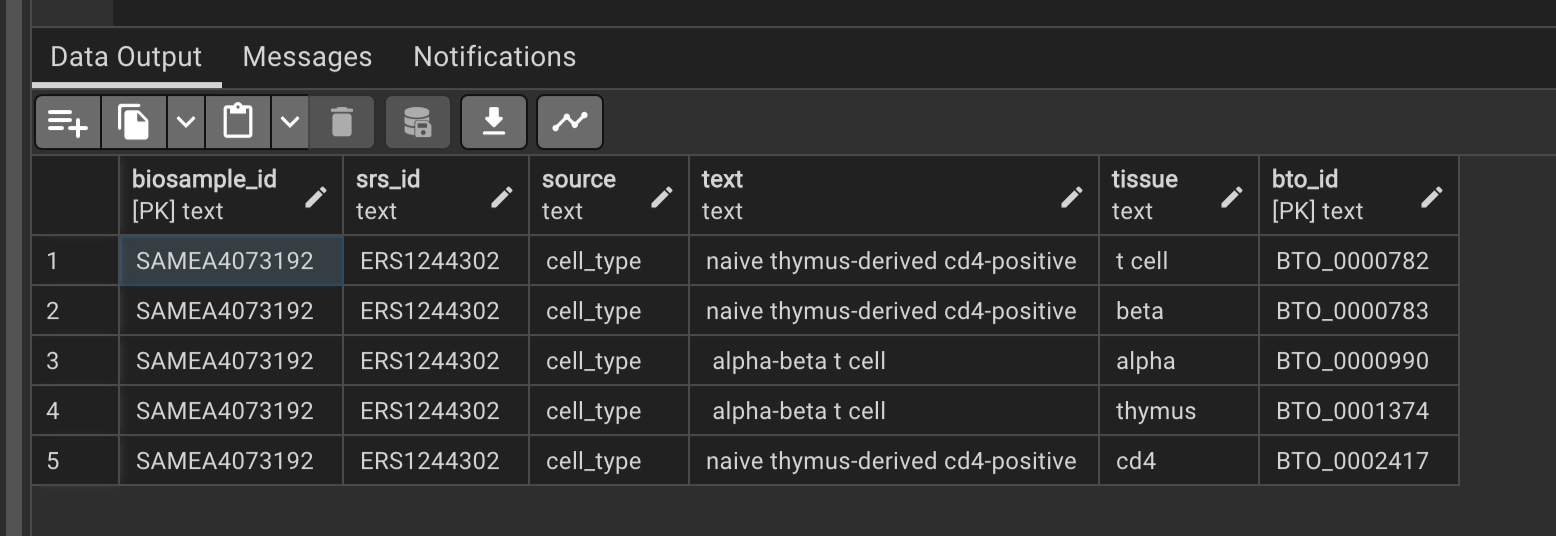

## Fixes
- all `','.join()` replaced with `'\t'.join()`
    - when exporting, split by tab rather than comma

----
# Issues with rerun round 3
- regular expression for preprocessing doesn't remove '/'
